## Moscow Exchange Index
#### 10.03.2019

In [1]:
# сonnect the necessary packages
from os import chdir 
import numpy as np
import pandas as pd
from pandas_datareader import data
from scipy import stats
import scipy.optimize as sco
import scipy.interpolate as sci
import matplotlib.pyplot as plt 
import random
chdir('C:/Users/Auriliano/Documents/Python')

In [2]:
# specify the data to load
Blue_moex = ['ALRS.ME', 'CHMF.ME', 'FIVE.ME', 'GAZP.ME', 'GMKN.ME', 'LKOH.ME', 'MGNT.ME', 'MTSS.ME',
          'NVTK.ME', 'ROSN.ME', 'SBER.ME', 'SNGS.ME', 'TATN.ME', 'VTBR.ME', 'YNDX.ME']
# list of asset weights on moex
moex_weights = [0.0276, 0.0208, 0.0218, 0.1482, 0.0736, 0.2047, 0.0338, 0.0276, 0.07, 0.0554,
                 0.172, 0.0272, 0.0631, 0.0148, 0.0394]
# number of assets
n_assets = len(Blue_moex)

In [3]:
# download data form yahoo
Blue = data.DataReader(Blue_moex, 
                       start='2018-02-12', 
                       end='2019-02-12', 
                       data_source='yahoo')['Close']

In [4]:
# get daily returns
Blue = Blue.apply(lambda x: np.log(x)-np.log(x).shift(1))
Blue.dropna(inplace = True)
Blue.head()

Symbols,ALRS.ME,CHMF.ME,FIVE.ME,GAZP.ME,GMKN.ME,LKOH.ME,MGNT.ME,MTSS.ME,NVTK.ME,ROSN.ME,SBER.ME,SNGS.ME,TATN.ME,VTBR.ME,YNDX.ME
Date,,,,,,,,,,,,,,,
2018-02-13,0.012888,0.030297,0.019331,0.018402,0.031177,0.019768,-0.004312,0.009917,0.001531,0.000307,0.012662,0.007763,0.025329,0.011605,0.003754
2018-02-14,-0.000233,-0.012396,0.004194,-0.006888,0.022442,-0.005512,-0.008265,-0.010582,0.015044,0.001842,0.014337,-0.007409,0.007701,0.000629,0.029991
2018-02-15,-0.006542,0.020435,-0.002794,-0.013263,0.002039,0.005646,0.006205,0.010582,0.016035,-0.005228,0.009685,0.000885,0.010772,-0.007365,0.037252
2018-02-16,0.005843,0.000000,-0.006784,0.000000,-0.086356,0.005614,-0.080919,0.007047,-0.005678,-0.000308,0.009068,0.008455,0.015944,0.007365,0.037813
2018-02-19,0.001048,-0.004117,-0.023994,0.009079,0.032850,-0.009644,-0.050905,0.001143,-0.011591,-0.000617,-0.000524,-0.000877,0.000088,-0.005255,0.018798


## Characteristics of assets

In [5]:
# profitableness
means = np.mean(Blue)
# Covariance matrix
cov = np.cov(Blue, rowvar=False)

## Helpfull functions

In [6]:
# profitability and volatility of the portfolio
def port(df, n_assets, N, n_days, cov, r_f):
    df['Mu'] = 0
    df['Volatility'] = 0
    for i in range(N + 1):
        # weights
        d = np.array(df.iloc[i, :n_assets])
        # Portfolio profitability
        df.iloc[i, (n_assets + 1)] = port_mean(d, means, n_days=250)
        # The volatility of the portfolio
        df.iloc[i, (n_assets + 2)] = port_vol(d, cov, n_days=250)
    df['Sharp_ratio'] = (df['Mu'] - r_f) / df['Volatility']


# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# Variation of the portfolio
def port_varianced(d, cov, n_days=250):
    d = np.array(d)
    return np.dot(d.T, np.dot(cov * n_days, d))


# Sharpe ratio 
def Sharpe_ratio(weights, cov, means, r_f, n_days=250):
    weights = np.array(weights)
    mean = np.sum(means * weights) * n_days
    vol = np.sqrt(np.dot(weights.T, np.dot(cov * n_days, weights)))
    return -((mean-r_f)/vol)


# generator weights of the assets in the portfolio
def port_weight(n_assets):
    weights = []
    for i in range(n_assets):
        mu = moex_weights[i]
        std = 0.2
        d = round(random.normalvariate(mu, std), 4)
        weights.append(d)
    if sum(weights) != 1:
        diff = 1- sum(weights)
        diff /= n_assets
        weights = [i + diff for i in weights]
        return weights


# Generating portfolio 
def portfolio(df, n_assets, N, n_days, cov, r_f):
    for i in range(1, N + 1):
        weight = np.array(port_weight(n_assets))
        df.loc[i] = weight
    df['Sum'] = df.sum(axis=1)
    port(df, n_assets, N, n_days, cov, r_f)

In [10]:
# Create dataframe with weights form Moscow Exchange
m_w = dict()
temp = []
for i in range(n_assets):
    temp.append(moex_weights[i])
    m_w[Blue_moex[i]] = temp
    temp = []
df = pd.DataFrame(m_w)
# Number of portfolio
N = 7500
# number of settlement days
n_days = len(Blue.index)
# Covariance matrix
cov = np.cov(Blue,rowvar=False)
# Risk free rate
r_f = 0.075

In [11]:
portfolio(df, n_assets, N, n_days, cov, r_f)
df.head()

,ALRS.ME,CHMF.ME,FIVE.ME,GAZP.ME,GMKN.ME,LKOH.ME,MGNT.ME,MTSS.ME,NVTK.ME,ROSN.ME,SBER.ME,SNGS.ME,TATN.ME,VTBR.ME,YNDX.ME,Sum,Mu,Volatility,Sharp_ratio
0,0.0276,0.0208,0.0218,0.1482,0.0736,0.2047,0.0338,0.0276,0.0700,0.0554,0.1720,0.0272,0.0631,0.0148,0.0394,1.0,0.133637,0.185556,0.316007
1,0.1032,0.1827,-0.4544,0.2892,0.1007,0.6530,0.0651,-0.1400,0.0174,-0.0530,0.0799,-0.1759,0.2343,0.0366,0.0612,1.0,0.502739,0.275415,1.553070
2,0.2201,-0.2037,-0.3538,0.0336,0.7771,0.3559,0.0046,0.3515,-0.0990,0.0730,-0.0466,0.2599,-0.1451,0.1012,-0.3287,1.0,0.169756,0.309438,0.306218
3,0.2119,0.2302,-0.0078,-0.2223,0.0568,0.4392,0.1163,-0.0016,-0.4425,0.1037,0.2950,-0.0901,0.3742,-0.2415,0.1785,1.0,0.164405,0.266501,0.335475
4,0.1601,0.2540,-0.1483,0.4036,0.2006,0.1709,-0.0275,-0.1013,-0.2284,0.0311,0.4421,0.3333,-0.4948,0.0507,-0.0461,1.0,-0.119043,0.274536,-0.706803


In [12]:
rets = np.array(df['Mu'])
vols = np.array(df['Volatility'])
MOEXBC_rent = df.iloc[0, (n_assets + 1)]
MOEXBC_vol = df.iloc[0, (n_assets + 2)]
MOEXBC_sharp = df.iloc[0, (n_assets + 3)]
print('Blue-chip index Sharp ratio:', round(MOEXBC_sharp, 4))
for i in range(N):
    if df.iloc[i, 18] <= 0:
        df.iloc[i, 18] = 0

Blue-chip index Sharp ratio: 0.316


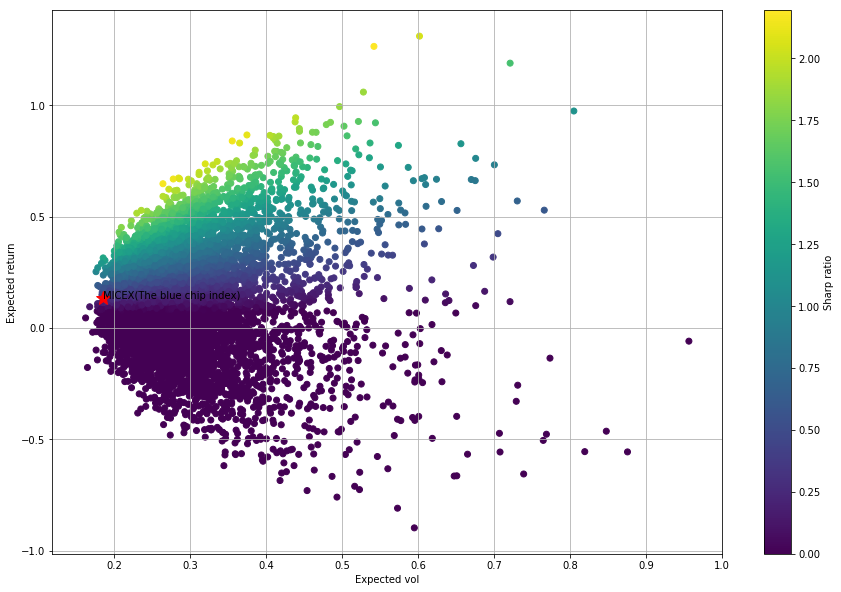

In [13]:
vols = np.array(df['Volatility'])
rets = np.array(df['Mu'])
sharpe = np.array(df['Sharp_ratio'])
_=plt.figure(figsize = (15, 10))
_=plt.scatter(vols, rets, c = sharpe, marker='o')
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label = 'Sharp ratio')
_=plt.plot(df.iloc[0, 17], df.iloc[0, 16], 'r*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy = (MOEXBC_vol, MOEXBC_rent))

In [14]:
Blue_sharp = df.sort_values(['Sharp_ratio']).iloc[::-1]
Blue_sharp = Blue_sharp[Blue_sharp['Sharp_ratio'] > MOEXBC_sharp]
Blue_sharp.head()

,ALRS.ME,CHMF.ME,FIVE.ME,GAZP.ME,GMKN.ME,LKOH.ME,MGNT.ME,MTSS.ME,NVTK.ME,ROSN.ME,SBER.ME,SNGS.ME,TATN.ME,VTBR.ME,YNDX.ME,Sum,Mu,Volatility,Sharp_ratio
5873,0.1210,-0.0510,-0.2911,0.0386,-0.0012,2.2674,-0.3624,-0.4404,-0.0484,0.1633,-0.0275,0.0250,0.2423,-0.4334,-0.2022,1.0,1.264109,0.541980,2.194007
1993,0.4270,-0.0539,-0.0635,0.0563,0.0349,0.2431,0.0286,-0.3067,0.3969,0.0141,-0.4182,0.1302,0.3684,-0.2089,0.3517,1.0,0.647378,0.264260,2.165962
1708,0.0576,-0.0519,0.0691,0.3825,0.1106,0.2284,-0.1721,-0.3249,1.0323,-0.1200,-0.3559,-0.1253,0.0999,-0.2433,0.4130,1.0,0.839364,0.355486,2.150195
6237,-0.2169,-0.1153,0.0460,0.1829,0.2570,0.6151,-0.1761,0.0146,0.4946,0.0441,-0.3528,-0.0175,0.2745,-0.0114,-0.0388,1.0,0.668557,0.277832,2.136392
429,0.3927,-0.1125,-0.2121,-0.1754,-0.0462,1.2936,-0.1035,-0.4168,-0.0712,0.2457,-0.0459,0.0033,0.5217,-0.1623,-0.1111,1.0,0.866302,0.374795,2.111296


#### The number of generated portfolios with Sharpe ratio is greater than the "Blue Chip Index"

In [15]:
len(Blue_sharp.index)

3331

#### The share of generated portfolios with Sharpe ratio is greater than that of the "Blue Chip Index"

In [16]:
print(round(len(Blue_sharp.index) / len(df.index) * 100, 2), '%', sep='')
percent = round(len(Blue_sharp.index) / len(df.index) * 100, 2)

44.41%


## The share of generated portfolios with Sharpe ratio is higher than that of the Blue chip Index 44.41%

## We construct a graph with the efficient frontier of portfolios

In [17]:
# the minimum and maximum portfolio returns
min_ret = -.12
max_ret = .4
print('the minimum portfolio returns: ', round(min_ret, 4) * 100, '%', sep='')
print('the maximum portfolio returns: ', round(max_ret, 4) * 100, '%', sep='')

the minimum portfolio returns: -12.0%
the maximum portfolio returns: 40.0%


In [18]:
# create an array of returns 
lrets = np.linspace(min_ret,max_ret,100)
# create an array of volatility
lvols = []

In [19]:
# portfolio with equal weights on all assets
w_initial = n_assets*[1./n_assets]
# the restriction weights of the assets
bnds = tuple((0, 1) for x in range(n_assets))

In [20]:
# restriction - the sum of weights should not exceed one
cons=({'type':'eq','fun':lambda x:sum(x)-1})

In [21]:
# portfolio with minimum variance
min_vari = sco.minimize(port_varianced, w_initial, cov, method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with minimum variance:',*min_vari['x'].round(3))
# portfolio with maximum Sharp ratio
max_sharp = sco.minimize(Sharpe_ratio, w_initial, (cov, means, r_f), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with maximum Sharp ratio:', *max_sharp['x'].round(3))

Weights of portfolio with minimum variance: 0.087 0.123 0.0 0.0 0.0 0.0 0.091 0.027 0.0 0.077 0.0 0.469 0.025 0.08 0.022
Weights of portfolio with maximum Sharp ratio: 0.0 0.0 0.0 0.0 0.0 0.441 0.0 0.0 0.375 0.0 0.0 0.0 0.184 0.0 0.0


In [22]:
# for each value of profitability, we find the portfolio with minimum volatility
for ret in lrets:
    cons = ({'type':'eq', 'fun':lambda x: sum(x)-1}, {'type':'eq', 'fun':lambda x: port_mean(x, means) - ret})
    res = sco.minimize(port_vol, w_initial, cov , method = 'SLSQP', bounds = bnds, constraints = cons)
    lvols.append(res['fun'])
# an array of the volatility of the efficient frontier
lvols = np.array(lvols)

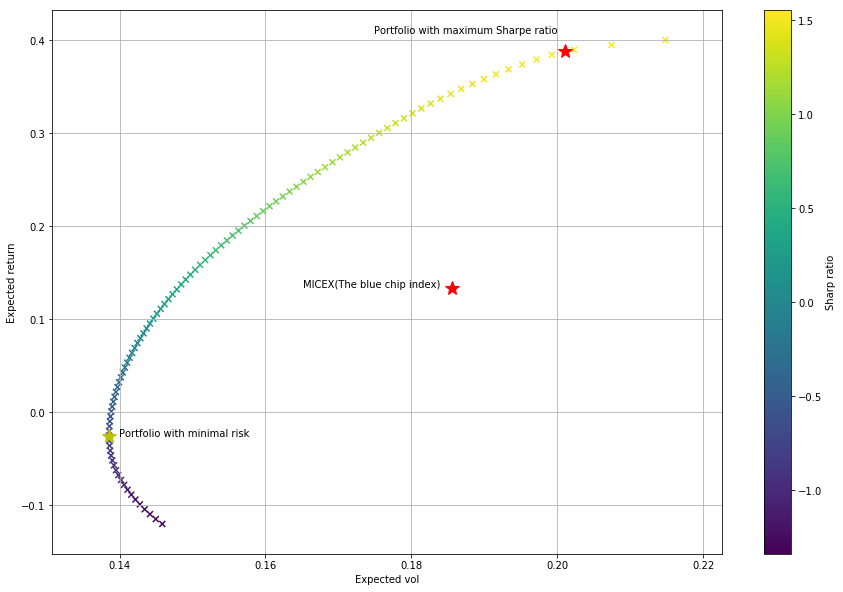

In [23]:
_=plt.figure(figsize = (15, 10))
_=plt.scatter(lvols, lrets,c = (lrets-r_f) / lvols, marker = 'x')
_=plt.plot(port_vol(max_sharp['x'], cov), port_mean(max_sharp['x'], means),'r*', markersize=15)
_=plt.plot(port_vol(min_vari['x'], cov), port_mean(min_vari['x'], means), 'y*', markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent))
_=plt.annotate('Portfolio with minimal risk ', xy=(port_vol(min_vari['x'], cov) * 1.01, port_mean(min_vari['x'], means)))
_=plt.annotate('Portfolio with maximum Sharpe ratio', xy=(port_vol(max_sharp['x'], cov) * .87,
                                                          port_mean(max_sharp['x'], means) * 1.05))

## Draw a CML line on the chart

In [24]:
# maximum volatility value
max_vol = max(lvols)
# index of the value with minimal volatility in the volatility array of the effective boundary
ind = np.argmin(lvols)
# part of the efficient frontier above the minimum-volatility
evols = lvols[ind:]
erets = lrets[ind:]
# spline interpolation (node calculation)
tck = sci.splrep(evols, erets)

## Function for CML

In [27]:
# Spline interpolation
def f(x, tck):
    return sci.splev(x, tck, der=0)


# spline interpolation (first derivative)
def df(x, tck):
    return sci.splev(x, tck, der=1)

# CML
def equations(p, r_f, tck):
    eq1 = r_f - p[0]
    eq2 = r_f + p[1] * p[2] - f(p[2],tck)
    eq3 = p[1] - df(p[2], tck)
    return eq1, eq2, eq3

In [28]:
# the tangent to the efficiency frontier
opt = sco.fsolve(equations,[0.02, 0.3, 0.15],(r_f,tck))
opt

array([0.075     , 1.55528574, 0.20130842])

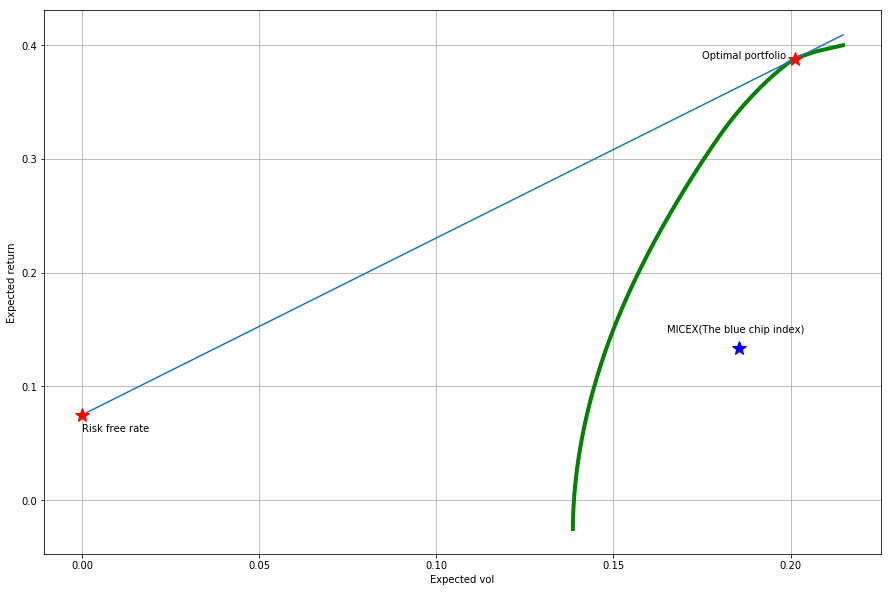

In [29]:
_=plt.figure(figsize = (15,10))
_=plt.plot(evols, erets, 'g', lw = 4.0)
cx = np.linspace(0, max(lvols))
_=plt.plot(cx, opt[0] + opt[1] * cx, lw = 1.5)
_=plt.plot(opt[2], f(opt[2], tck),'r*',markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'b*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent * 1.1))
_=plt.annotate('Optimal portfolio', xy=(opt[2] * .87, f(opt[2], tck)))
_=plt.plot(0, r_f, 'r*', markersize=15)
_=plt.annotate('Risk free rate', xy=(0, r_f * 0.8))

### As you can see, the blue chip index does not match the optimal portfolio of the same assets

In [30]:
# tangent portfolio
res = sco.minimize(port_vol, w_initial, (cov), method = 'SLSQP', bounds = bnds,constraints = cons)

In [32]:
# tangent portfolio
res = sco.minimize(port_vol, w_initial, (cov), method = 'SLSQP', bounds = bnds,constraints = cons)
# weights of tangent portfolio
dt = dict(Tiket = Blue_moex, Weights = list(res['x']))
dt = pd.DataFrame(dt)
dt = dt[dt['Weights'] > 0.0001]
print(dt)
# # profitability
print('Profitability: ', np.around(f(opt[2],tck) * 100, 2), '%', sep='')

     Tiket   Weights
5  LKOH.ME  0.456585
8  NVTK.ME  0.543415
Profitability: 38.81%


### The optimal portfolio consists of LKOH - 45,7% and NVTK - 54,3%
### This portfolio has a yield: 38,81%

# We will conduct the same study for the MICEX index

In [33]:
# specify the data to load
MICEX_moex = ['AFKS.ME', 'AFLT.ME', 'ALRS.ME', 'CBOM.ME', 'CHMF.ME', 'DSKY.ME', 'FEES.ME', 'FIVE.ME',
             'GAZP.ME', 'GMKN.ME', 'HYDR.ME', 'IRAO.ME', 'LKOH.ME', 'LNTA.ME', 'MAGN.ME', 'MGNT.ME',
             'MOEX.ME', 'MTLR.ME', 'MTSS.ME', 'MVID.ME', 'NLMK.ME', 'NVTK.ME', 'PHOR.ME', 'PIKK.ME',
             'PLZL.ME', 'POLY.ME', 'RNFT.ME', 'ROSN.ME', 'RTKM.ME', 'RUAL.ME', 'SBER.ME', 'SBERP.ME',
             'SFIN.ME', 'SNGS.ME', 'SNGSP.ME', 'TATN.ME', 'TATNP.ME', 'TRMK.ME', 'TRNFP.ME', 'UPRO.ME',
             'VTBR.ME', 'YNDX.ME']
# list of asset weights on moex
moex_weights = [0.0033, 0.0049, 0.0226, 0.0028, 0.0167, 0.0022, 0.0037, 0.0178, 0.1195, 0.0627, 0.0039,
                0.0129, 0.168, 0.0026, 0.0076, 0.0272, 0.0121, 0.0015, 0.0223, 0.0023, 0.0155, 0.0566,
                0.0081, 0.0041, 0.0108, 0.0125, 0.0034, 0.0457, 0.0059, 0.0075, 0.1405, 0.0118, 0.0026,
                0.0219, 0.0221, 0.0509, 0.0077, 0.0014, 0.0079, 0.0026, 0.012, 0.0319]
# number of assets
n_assets = len(MICEX_moex)

In [34]:
# download data form yahoo
MICEX = data.DataReader(MICEX_moex, 
                       start='2018-02-12', 
                       end='2019-02-12', 
                       data_source='yahoo')['Close']
# get daily returns
MICEX = MICEX.apply(lambda x: np.log(x)-np.log(x).shift(1))
MICEX.dropna(inplace = True)
MICEX.head()

Symbols,AFKS.ME,AFLT.ME,ALRS.ME,CBOM.ME,CHMF.ME,DSKY.ME,FEES.ME,FIVE.ME,GAZP.ME,GMKN.ME,...,SFIN.ME,SNGS.ME,SNGSP.ME,TATN.ME,TATNP.ME,TRMK.ME,TRNFP.ME,UPRO.ME,VTBR.ME,YNDX.ME
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-13,-0.026433,0.009309,0.012888,0.008818,0.030297,0.002207,0.015968,0.019331,0.018402,0.031177,...,-0.009839,0.007763,0.011201,0.025329,0.000513,0.002508,0.016998,0.021053,0.011605,0.003754
2018-02-14,-0.005698,-0.018706,-0.000233,-0.002358,-0.012396,-0.001655,0.001413,0.004194,-0.006888,0.022442,...,-0.005288,-0.007409,-0.006505,0.007701,-0.003080,0.004997,0.013393,-0.009897,0.000629,0.029991
2018-02-15,-0.011494,-0.006192,-0.006542,0.000858,0.020435,-0.004982,0.005634,-0.002794,-0.013263,0.002039,...,0.000000,0.000885,-0.001004,0.010772,0.019349,0.009302,-0.000277,0.013301,-0.007365,0.037252
2018-02-16,0.007404,0.003283,0.005843,0.001500,0.000000,0.000000,-0.002813,-0.006784,0.000000,-0.086356,...,-0.009321,0.008455,-0.006217,0.015944,0.008786,-0.013048,0.000554,0.010141,0.007365,0.037813
2018-02-19,0.016261,0.000364,0.001048,-0.001071,-0.004117,-0.001110,-0.010762,-0.023994,0.009079,0.032850,...,-0.023690,-0.000877,-0.007444,0.000088,0.005235,0.005613,-0.002497,0.006704,-0.005255,0.018798


In [35]:
# profitableness
means = np.mean(MICEX)
# Covariance matrix
cov = np.cov(MICEX, rowvar=False)

In [37]:
# Create dataframe with weights form Moscow Exchange
m_w = dict()
temp = []
for i in range(n_assets):
    temp.append(moex_weights[i])
    m_w[MICEX_moex[i]] = temp
    temp = []
df = pd.DataFrame(m_w)
# Number of portfolio
N = 7500
# number of settlement days
n_days = len(MICEX.index)
# Covariance matrix
cov = np.cov(MICEX,rowvar=False)
# Risk free rate
r_f = 0.075

In [38]:
portfolio(df, n_assets, N, n_days, cov, r_f)
df.head()

,AFKS.ME,AFLT.ME,ALRS.ME,CBOM.ME,CHMF.ME,DSKY.ME,FEES.ME,FIVE.ME,GAZP.ME,GMKN.ME,...,TATNP.ME,TRMK.ME,TRNFP.ME,UPRO.ME,VTBR.ME,YNDX.ME,Sum,Mu,Volatility,Sharp_ratio
0,0.0033,0.0049,0.0226,0.0028,0.0167,0.0022,0.0037,0.0178,0.1195,0.0627,...,0.0077,0.0014,0.0079,0.0026,0.0120,0.0319,1.0,0.112139,0.172667,0.215092
1,-0.2587,-0.0516,0.1998,0.3771,-0.3730,-0.0724,0.2144,-0.2362,-0.1169,-0.0268,...,-0.4411,0.3368,0.0035,-0.0574,-0.0406,-0.1819,1.0,0.122013,0.363499,0.129336
2,0.3467,0.2295,-0.3507,0.0768,0.2309,0.2097,0.1635,0.2294,0.4584,0.1765,...,0.1152,0.0222,0.1964,0.1462,0.1942,0.0671,1.0,0.427098,0.319361,1.102506
3,0.0933,0.4007,-0.0008,0.0965,0.1325,-0.0401,-0.2690,0.1586,0.3003,-0.3060,...,-0.1066,0.1612,-0.0823,0.0147,0.0566,0.1064,1.0,-0.497624,0.406674,-1.408065
4,0.0524,-0.0121,0.0023,0.2911,0.2919,-0.1263,-0.0191,0.1858,0.3198,0.0150,...,0.2587,0.1656,-1.8299,0.1198,-0.0747,0.3230,1.0,0.543942,0.532291,0.880988


In [39]:
rets = np.array(df['Mu'])
vols = np.array(df['Volatility'])
MICEX_rent = df.iloc[0, 43]
MICEX_vol = df.iloc[0, 44]
MICEX_sharp = df.iloc[0, 45]
print('MICEX index Sharp ratio:', round(MICEX_sharp, 4))

MICEX index Sharp ratio: 0.2151


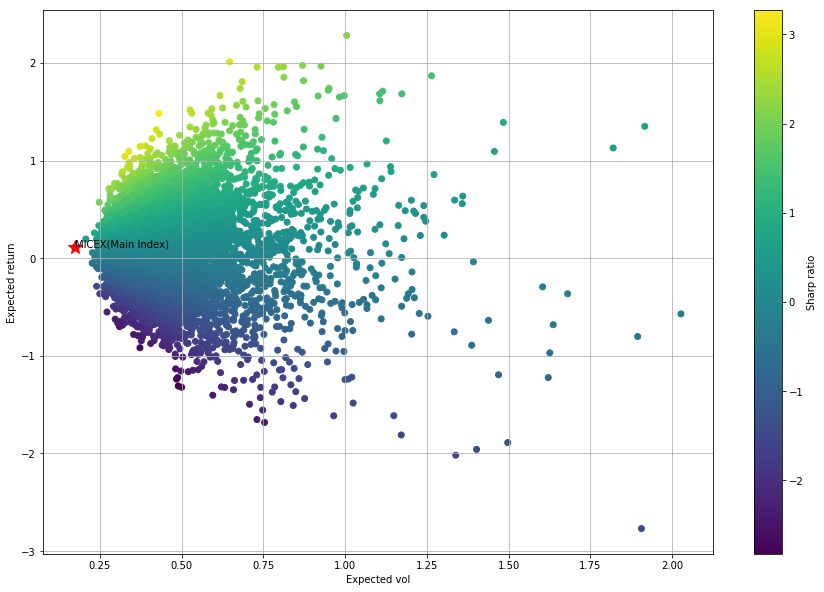

In [40]:
vols = np.array(df['Volatility'])
rets = np.array(df['Mu'])
sharpe = np.array(df['Sharp_ratio'])
_=plt.figure(figsize = (15, 10))
_=plt.scatter(vols, rets, c = sharpe, marker='o')
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label = 'Sharp ratio')
_=plt.plot(MICEX_vol, MICEX_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(Main Index)', xy = (MICEX_vol, MICEX_rent))

In [41]:
MICEX_sharp = df.sort_values(['Sharp_ratio']).iloc[::-1]
MICEX_sharp = Blue_sharp[Blue_sharp['Sharp_ratio'] > MOEXBC_sharp]
MICEX_sharp.head()

,ALRS.ME,CHMF.ME,FIVE.ME,GAZP.ME,GMKN.ME,LKOH.ME,MGNT.ME,MTSS.ME,NVTK.ME,ROSN.ME,SBER.ME,SNGS.ME,TATN.ME,VTBR.ME,YNDX.ME,Sum,Mu,Volatility,Sharp_ratio
5873,0.1210,-0.0510,-0.2911,0.0386,-0.0012,2.2674,-0.3624,-0.4404,-0.0484,0.1633,-0.0275,0.0250,0.2423,-0.4334,-0.2022,1.0,1.264109,0.541980,2.194007
1993,0.4270,-0.0539,-0.0635,0.0563,0.0349,0.2431,0.0286,-0.3067,0.3969,0.0141,-0.4182,0.1302,0.3684,-0.2089,0.3517,1.0,0.647378,0.264260,2.165962
1708,0.0576,-0.0519,0.0691,0.3825,0.1106,0.2284,-0.1721,-0.3249,1.0323,-0.1200,-0.3559,-0.1253,0.0999,-0.2433,0.4130,1.0,0.839364,0.355486,2.150195
6237,-0.2169,-0.1153,0.0460,0.1829,0.2570,0.6151,-0.1761,0.0146,0.4946,0.0441,-0.3528,-0.0175,0.2745,-0.0114,-0.0388,1.0,0.668557,0.277832,2.136392
429,0.3927,-0.1125,-0.2121,-0.1754,-0.0462,1.2936,-0.1035,-0.4168,-0.0712,0.2457,-0.0459,0.0033,0.5217,-0.1623,-0.1111,1.0,0.866302,0.374795,2.111296


#### The number of generated portfolios with Sharpe ratio is greater than the "Main Index of Moscow Exchange (MOEX)"

In [42]:
len(MICEX_sharp.index)

3331

#### The share of generated portfolios with Sharpe ratio is greater than that of the "Blue Chip Index"

In [43]:
print(round(len(Blue_sharp.index) / len(df.index) * 100, 2), '%', sep='')
percent = round(len(Blue_sharp.index) / len(df.index) * 100, 2)

44.41%


## The share of generated portfolios with Sharpe ratio is higher than that of the Main Index of Moscow Exchange 44.41%

## We construct a graph with the efficient frontier of portfolios


In [44]:
# the minimum and maximum portfolio returns
min_ret = -.12
max_ret = .4
print('the minimum portfolio returns: ', round(min_ret, 4) * 100, '%', sep='')
print('the maximum portfolio returns: ', round(max_ret, 4) * 100, '%', sep='')

the minimum portfolio returns: -12.0%
the maximum portfolio returns: 40.0%


In [45]:
# restriction - the sum of weights should not exceed one
cons=({'type':'eq','fun':lambda x:sum(x)-1})
# create an array of returns 
lrets = np.linspace(min_ret,max_ret,100)
# create an array of volatility
lvols = []
# portfolio with equal weights on all assets
w_initial = n_assets*[1./n_assets]
# the restriction weights of the assets
bnds = tuple((0, 1) for x in range(n_assets))

In [46]:
# portfolio with minimum variance
min_vari = sco.minimize(port_varianced, w_initial, (cov), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with minimum variance:',*min_vari['x'].round(3))
# portfolio with maximum Sharp ratio
max_sharp = sco.minimize(Sharpe_ratio, w_initial, (cov, means, r_f), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with maximum Sharp ratio:', *max_sharp['x'].round(3))

Weights of portfolio with minimum variance: 0.0 0.0 0.0 0.197 0.0 0.1 0.0 0.0 0.0 0.0 0.003 0.0 0.0 0.0 0.0 0.0 0.027 0.0 0.0 0.027 0.0 0.0 0.11 0.204 0.0 0.0 0.0 0.0 0.12 0.0 0.0 0.0 0.01 0.085 0.0 0.0 0.021 0.056 0.015 0.023 0.0 0.0
Weights of portfolio with maximum Sharp ratio: 0.0 0.0 0.0 0.135 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.209 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.183 0.0 0.165 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.154 0.0 0.154 0.0 0.0 0.0 0.0 0.0


In [47]:
# for each value of profitability, we find the portfolio with minimum volatility
for ret in lrets:
    cons = ({'type':'eq', 'fun':lambda x: sum(x)-1}, {'type':'eq', 'fun':lambda x: port_mean(x, means) - ret})
    res = sco.minimize(port_vol, w_initial, cov , method = 'SLSQP', bounds = bnds, constraints = cons)
    lvols.append(res['fun'])
# an array of the volatility of the efficient frontier
lvols = np.array(lvols)

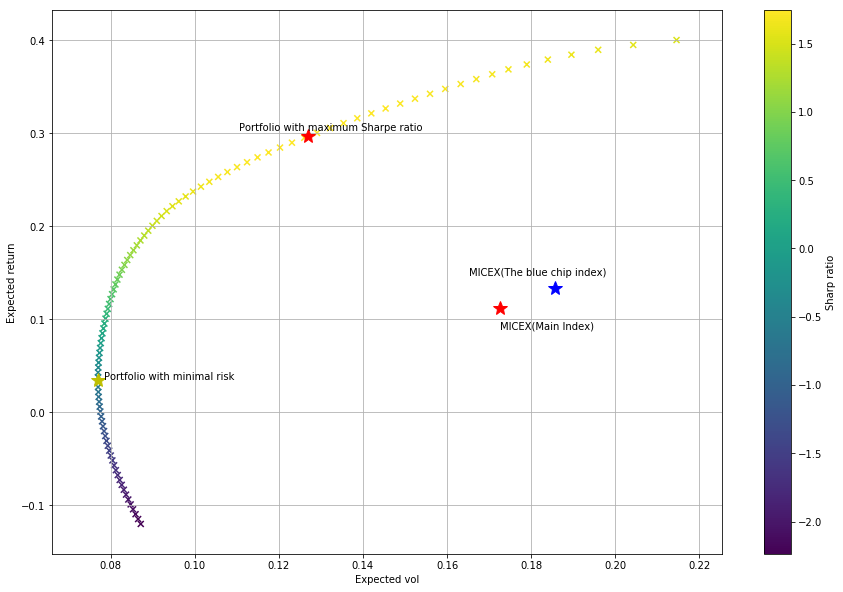

In [52]:
_=plt.figure(figsize = (15, 10))
_=plt.scatter(lvols, lrets,c = (lrets-r_f) / lvols, marker = 'x')
_=plt.plot(port_vol(max_sharp['x'], cov), port_mean(max_sharp['x'], means),'r*', markersize=15)
_=plt.plot(port_vol(min_vari['x'], cov), port_mean(min_vari['x'], means), 'y*', markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'b*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent * 1.1))
_=plt.plot(MICEX_vol, MICEX_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(Main Index)', xy = (MICEX_vol, MICEX_rent * .8))
_=plt.annotate('Portfolio with minimal risk ', xy=(port_vol(min_vari['x'], cov) * 1.02, port_mean(min_vari['x'], means)))
_=plt.annotate('Portfolio with maximum Sharpe ratio', xy=(port_vol(max_sharp['x'], cov) * .87, 
                                                          port_mean(max_sharp['x'], means) * 1.02))


## Draw a CML line on the chart

In [53]:
# maximum volatility value
max_vol = max(lvols)
# index of the value with minimal volatility in the volatility array of the effective boundary
ind = np.argmin(lvols)
# part of the efficient frontier above the minimum-volatility
evols = lvols[ind:]
erets = lrets[ind:]
# spline interpolation (node calculation)
tck = sci.splrep(evols, erets)

## Function for CML

In [55]:
# Spline interpolation
def f(x, tck):
    return sci.splev(x, tck, der=0)


# spline interpolation (first derivative)
def df(x, tck):
    return sci.splev(x, tck, der=1)

# CML
def equations(p, r_f, tck):
    eq1 = r_f - p[0]
    eq2 = r_f + p[1] * p[2] - f(p[2],tck)
    eq3 = p[1] - df(p[2], tck)
    return eq1, eq2, eq3

In [56]:
# the tangent to the efficiency frontier
opt = sco.fsolve(equations, [0.02, 0.3, 0.15],(r_f,tck))
opt

array([0.075     , 1.74488305, 0.12701367])

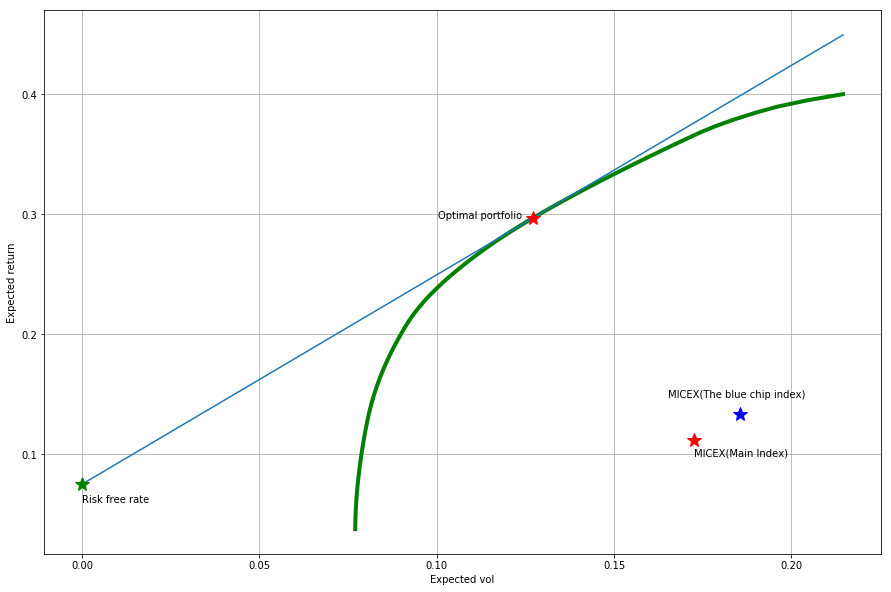

In [57]:
_=plt.figure(figsize = (15,10))
_=plt.plot(evols, erets, 'g', lw = 4.0)
cx = np.linspace(0, max(lvols))
_=plt.plot(cx, opt[0] + opt[1] * cx, lw = 1.5)
_=plt.plot(opt[2], f(opt[2], tck),'r*',markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'b*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent * 1.1))
_=plt.plot(MICEX_vol, MICEX_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(Main Index)', xy = (MICEX_vol, MICEX_rent * .88))
_=plt.annotate('Optimal portfolio', xy=(opt[2] * .79, f(opt[2], tck)))
_=plt.plot(0, r_f, 'g*', markersize=15)
_=plt.annotate('Risk free rate', xy=(0, r_f * 0.8))

### As you can see, the MICEX index does not match the optimal portfolio of the same assets

In [58]:
# tangent portfolio
res = sco.minimize(port_vol, w_initial, (cov), method = 'SLSQP', bounds = bnds,constraints = cons)
# weights of tangent portfolio
dt = dict(Tiket = MICEX_moex, Weights = list(res['x']))
dt = pd.DataFrame(dt)
dt = dt[dt['Weights'] > 0.0001]
print(dt)
# # profitability
print('Profitability: ', np.around(f(opt[2],tck) * 100, 2), '%', sep='')

       Tiket   Weights
12   LKOH.ME  0.412010
21   NVTK.ME  0.565024
36  TATNP.ME  0.022966
Profitability: 29.66%


### The optimal portfolio consists of LKOH - 41,2%, NVTK - 56,5% and TATNP - 2,3%
### This portfolio has a yield: 29,66%

# We will conduct the same study for the MOEXBMI (Broad market index)

In [59]:
# Download the file with the composition of the index
dbmi = pd.read_csv('BMI.csv', sep=';')
# specify the data to load
BMI_moex = [i + '.ME' for i in list(dbmi['Tik'])]
# list of asset weights on moex
moex_weights = list(dbmi['Share'])
# number of assets
n_assets = len(BMI_moex)

In [60]:
# download data form yahoo
BMI = data.DataReader(BMI_moex, 
                       start='2018-02-12', 
                       end='2019-02-12', 
                       data_source='yahoo')['Close']
# get daily returns
BMI = BMI.apply(lambda x: np.log(x)-np.log(x).shift(1))
BMI.dropna(inplace = True)
BMI.head()

Symbols,AFKS.ME,AFLT.ME,AGRO.ME,AKRN.ME,ALRS.ME,AMEZ.ME,APTK.ME,BANEP.ME,BRZL.ME,BSPB.ME,...,TGKD.ME,TGKN.ME,TRMK.ME,TRNFP.ME,TTLK.ME,UPRO.ME,UWGN.ME,VSMO.ME,VTBR.ME,YNDX.ME
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,-0.002575,-0.011886,-0.004298,0.009626,0.014389,-0.007905,-0.047356,0.000000,0.035932,-0.016065,...,-0.036258,-0.001921,-0.016301,-0.013447,-0.031749,0.017700,0.006694,-0.012195,-0.020154,0.003492
2018-06-20,0.013829,0.021506,-0.010101,0.003964,0.033499,0.002642,0.018228,0.005476,0.005865,0.009068,...,0.000000,0.000000,-0.014004,0.020251,0.005848,-0.003163,-0.006694,0.008552,0.043518,0.002828
2018-06-21,-0.019518,-0.003197,0.002173,0.000000,0.040609,0.000000,-0.009901,0.000287,0.005831,0.000000,...,0.000000,0.000000,-0.008368,-0.003248,-0.002920,0.002812,0.002236,0.006669,-0.005098,-0.013561
2018-06-22,-0.086069,-0.001068,-0.009451,-0.000233,0.004175,-0.015958,0.026188,-0.008658,-0.005831,-0.003014,...,-0.018634,0.000000,0.009649,0.019623,-0.008811,0.003504,-0.003730,-0.006061,-0.001492,-0.023845
2018-06-25,-0.010799,0.002490,0.002918,0.001628,0.017027,0.021221,-0.027848,-0.001450,-0.011765,0.008016,...,0.027823,0.000000,-0.009003,-0.003486,-0.002954,0.002794,-0.015820,-0.001825,-0.004060,-0.018207


In [61]:
# profitableness
means = np.mean(BMI)
# Covariance matrix
cov = np.cov(BMI, rowvar=False)

In [77]:
# Create dataframe with weights form Moscow Exchange
m_w = dict()
temp = []
for i in range(n_assets):
    temp.append(moex_weights[i])
    m_w[BMI_moex[i]] = temp
    temp = []
df = pd.DataFrame(m_w)
# Number of portfolio
N = 7500
# number of settlement days
n_days = len(BMI.index)
# Covariance matrix
cov = np.cov(BMI,rowvar=False)
# Risk free rate
r_f = 0.075

In [78]:
portfolio(df, n_assets, N, n_days, cov, r_f)
df.head()

,SBER.ME,SBERP.ME,LKOH.ME,GAZP.ME,GMKN.ME,NVTK.ME,TATN.ME,TATNP.ME,ROSN.ME,SNGS.ME,...,ROLO.ME,BRZL.ME,TTLK.ME,AMEZ.ME,RBCM.ME,HIMCP.ME,Sum,Mu,Volatility,Sharp_ratio
0,0.1384,0.0116,0.1500,0.1477,0.0724,0.0588,0.0462,0.0069,0.0397,0.0196,...,0.00004,0.00004,0.00004,0.00004,0.00003,0.00003,1.00047,0.084577,0.090117,0.106267
1,-0.2749,0.0018,0.1932,-0.0153,0.0676,-0.1159,0.1748,-0.0670,-0.0429,-0.0940,...,0.13290,0.13970,-0.00760,0.17490,-0.00610,-0.12530,1.00000,0.564664,0.916133,0.534489
2,-0.3299,0.0832,0.3108,0.3080,-0.0927,0.0770,-0.0463,0.1109,0.0842,0.0693,...,0.48020,-0.02120,0.49970,-0.03950,0.04850,0.01200,1.00000,0.117145,0.734010,0.057418
3,-0.0266,0.1273,0.3648,0.1724,0.2992,0.2551,0.0525,0.2173,0.1422,0.0998,...,0.11860,0.19930,0.05540,-0.11290,-0.13770,-0.10870,1.00000,1.012404,1.102758,0.850053
4,-0.1951,-0.1596,0.0033,0.5355,0.1336,0.3887,-0.1171,0.2805,0.0508,-0.0803,...,0.35700,-0.09230,0.00500,-0.08690,0.01470,0.21090,1.00000,0.151562,0.543056,0.140983


In [99]:
rets = np.array(df['Mu'])
vols = np.array(df['Volatility'])
BMI_rent = df.iloc[0, (n_assets + 1)]
BMI_vol = df.iloc[0, (n_assets + 2)]
BMI_sharp = df.iloc[0, (n_assets + 3)]
print('Broad market index Sharp ratio:', round(BMI_sharp, 4))

Broad market index Sharp ratio: 0.1063


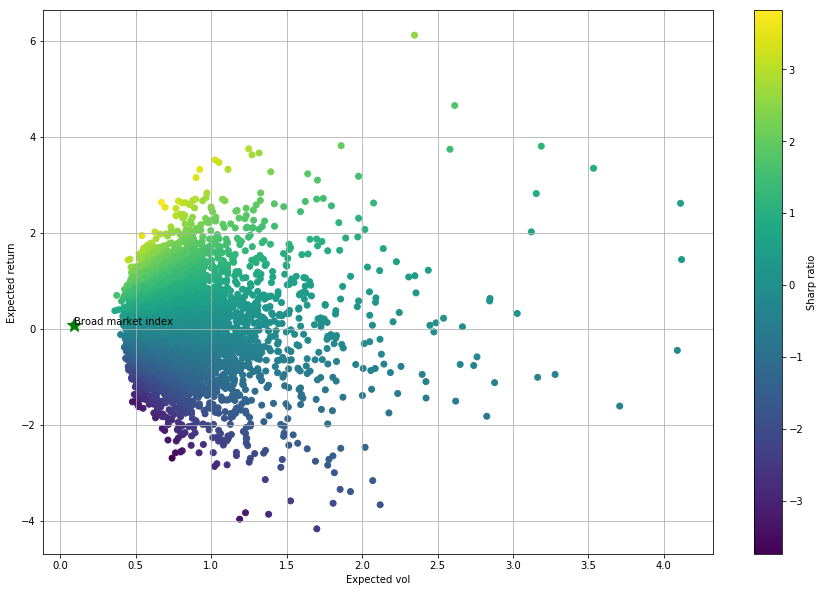

In [100]:
vols = np.array(df['Volatility'])
rets = np.array(df['Mu'])
sharpe = np.array(df['Sharp_ratio'])
_=plt.figure(figsize = (15, 10))
_=plt.scatter(vols, rets, c = sharpe, marker='o')
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label = 'Sharp ratio')
_=plt.plot(BMI_vol, BMI_rent, 'g*', markersize=15)
_=plt.annotate('Broad market index', xy = (BMI_vol, BMI_rent))

#### The number of generated portfolios with Sharpe ratio is greater than the "Broad market index"

In [83]:
BMI_sh = df.sort_values(['Sharp_ratio']).iloc[::-1]
BMI_sh = BMI_sh[BMI_sh['Sharp_ratio'] > BMI_sharp]
BMI_sh.head()

,SBER.ME,SBERP.ME,LKOH.ME,GAZP.ME,GMKN.ME,NVTK.ME,TATN.ME,TATNP.ME,ROSN.ME,SNGS.ME,...,ROLO.ME,BRZL.ME,TTLK.ME,AMEZ.ME,RBCM.ME,HIMCP.ME,Sum,Mu,Volatility,Sharp_ratio
6940,0.4141,0.0881,0.3890,0.4687,0.1793,0.4688,0.1389,-0.0272,0.0904,-0.1654,...,-0.0516,0.1465,-0.3464,0.1022,0.0857,-0.0145,1.0,2.632368,0.669648,3.818972
6836,0.3217,-0.2675,0.1222,0.2464,0.2289,0.2652,-0.1575,0.3013,0.0472,0.1131,...,-0.0324,-0.0635,0.2064,-0.1492,-0.2183,0.0806,1.0,2.529844,0.694434,3.535030
4583,0.1866,-0.2476,0.2274,0.4429,0.1269,0.3218,0.3645,0.0280,0.0656,0.0147,...,0.2016,-0.0451,0.1880,0.2107,-0.1194,0.0949,1.0,3.317910,0.924058,3.509421
4487,0.3589,-0.1545,0.1837,0.2429,0.0749,0.2587,0.1519,-0.0753,-0.0418,0.0113,...,-0.0165,-0.1246,-0.1378,-0.0903,-0.0723,-0.0480,1.0,1.941136,0.540943,3.449782
4609,0.3223,-0.2060,-0.0848,0.3158,-0.0443,0.2678,0.1469,0.1147,0.4530,-0.0038,...,0.0543,0.1885,-0.1274,0.1441,0.1208,0.1067,1.0,3.148652,0.899585,3.416743


#### The number of generated portfolios with Sharpe ratio is greater than the "Broad market index"

In [84]:
len(BMI_sh)

3708

#### The share of generated portfolios with Sharpe ratio is greater than that of the "Broad market index"

In [85]:
print(round(len(BMI_sh.index) / len(df.index) * 100, 2), '%', sep='')
percent = round(len(BMI_sh.index) / len(df.index) * 100, 2)

49.43%


### The share of generated portfolios with Sharpe ratio is higher than that of the Broad market index 49,43%

## We construct a graph with the efficient frontier of portfolios

In [91]:
# the minimum and maximum portfolio returns
min_ret = -.12
max_ret = .8
print('the minimum portfolio returns: ', round(min_ret, 4) * 100, '%', sep='')
print('the maximum portfolio returns: ', round(max_ret, 4) * 100, '%', sep='')

the minimum portfolio returns: -12.0%
the maximum portfolio returns: 80.0%


In [92]:
# restriction - the sum of weights should not exceed one
cons=({'type':'eq','fun':lambda x:sum(x)-1})
# create an array of returns 
lrets = np.linspace(min_ret,max_ret,100)
# create an array of volatility
lvols = []
# portfolio with equal weights on all assets
w_initial = n_assets*[1./n_assets]
# the restriction weights of the assets
bnds = tuple((0, 1) for x in range(n_assets))

In [93]:
# portfolio with minimum variance
min_vari = sco.minimize(port_varianced, w_initial, (cov), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with minimum variance:',*min_vari['x'].round(3))
# portfolio with maximum Sharp ratio
max_sharp = sco.minimize(Sharpe_ratio, w_initial, (cov, means, r_f), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with maximum Sharp ratio:', *max_sharp['x'].round(3))

Weights of portfolio with minimum variance: 0.0 0.0 0.07 0.044 0.0 0.013 0.009 0.0 0.039 0.0 0.065 0.0 0.0 0.009 0.0 0.013 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.015 0.0 0.0 0.021 0.0 0.041 0.0 0.0 0.0 0.004 0.0 0.0 0.022 0.0 0.0 0.019 0.0 0.0 0.0 0.028 0.0 0.0 0.0 0.0 0.019 0.0 0.0 0.0 0.0 0.0 0.031 0.0 0.0 0.0 0.0 0.005 0.0 0.042 0.111 0.006 0.022 0.029 0.015 0.001 0.0 0.0 0.0 0.0 0.0 0.0 0.027 0.03 0.0 0.0 0.0 0.025 0.06 0.0 0.023 0.024 0.006 0.0 0.0 0.0 0.0 0.0 0.007 0.053 0.025 0.0 0.006 0.004 0.019 0.0 0.0
Weights of portfolio with maximum Sharp ratio: 0.0 0.0 0.102 0.0 0.0 0.012 0.0 0.0 0.0 0.0 0.009 0.0 0.0 0.0 0.0 0.014 0.027 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.035 0.0 0.0 0.0 0.055 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.091 0.0 0.0 0.012 0.0 0.0 0.001 0.079 0.026 0.079 0.0 0.0 0.102 0.0 0.0 0.0 0.0 0.018 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.233 0.0 0.0 0.107 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0


In [94]:
# for each value of profitability, we find the portfolio with minimum volatility
for ret in lrets:
    cons = ({'type':'eq', 'fun':lambda x: sum(x)-1}, {'type':'eq', 'fun':lambda x: port_mean(x, means) - ret})
    res = sco.minimize(port_vol, w_initial, cov , method = 'SLSQP', bounds = bnds, constraints = cons)
    lvols.append(res['fun'])
# an array of the volatility of the efficient frontier
lvols = np.array(lvols)

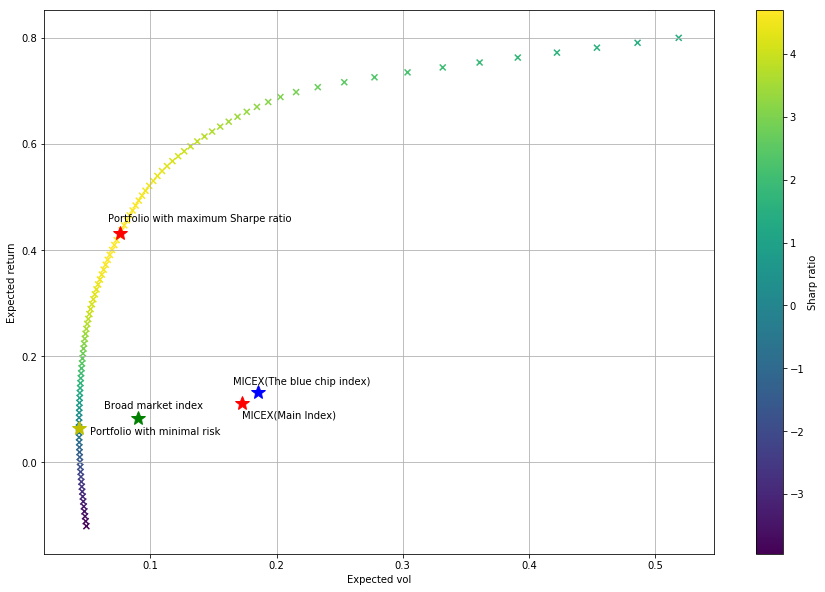

In [104]:
_=plt.figure(figsize = (15, 10))
_=plt.scatter(lvols, lrets,c = (lrets-r_f) / lvols, marker = 'x')
_=plt.plot(port_vol(max_sharp['x'], cov), port_mean(max_sharp['x'], means),'r*', markersize=15)
_=plt.plot(port_vol(min_vari['x'], cov), port_mean(min_vari['x'], means), 'y*', markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.colorbar(label='Sharp ratio')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'b*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent * 1.1))
_=plt.plot(MICEX_vol, MICEX_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(Main Index)', xy = (MICEX_vol, MICEX_rent * .75))
_=plt.plot(BMI_vol, BMI_rent, 'g*', markersize=15)
_=plt.annotate('Broad market index', xy = (BMI_vol * .7, BMI_rent * 1.2))
_=plt.annotate('Portfolio with minimal risk ', xy=(port_vol(min_vari['x'], cov) * 1.2, 
                                                   port_mean(min_vari['x'], means) * .8))
_=plt.annotate('Portfolio with maximum Sharpe ratio', xy=(port_vol(max_sharp['x'], cov) * .87,
                                                          port_mean(max_sharp['x'], means) * 1.05))

## Draw a CML line on the chart

## Function for CML

In [106]:
# Spline interpolation
def f(x, tck):
    return sci.splev(x, tck, der=0)


# spline interpolation (first derivative)
def df(x, tck):
    return sci.splev(x, tck, der=1)

# CML
def equations(p, r_f, tck):
    eq1 = r_f - p[0]
    eq2 = r_f + p[1] * p[2] - f(p[2],tck)
    eq3 = p[1] - df(p[2], tck)
    return eq1, eq2, eq3

In [107]:
# maximum volatility value
max_vol = max(lvols)
# index of the value with minimal volatility in the volatility array of the effective boundary
ind = np.argmin(lvols)
# part of the efficient frontier above the minimum-volatility
evols = lvols[ind:]
erets = lrets[ind:]
# spline interpolation (node calculation)
tck = sci.splrep(evols, erets)
# the tangent to the efficiency frontier
opt = sco.fsolve(equations, [0.02, 0.3, 0.15],(r_f,tck))
opt

array([0.075     , 4.69572806, 0.07621733])

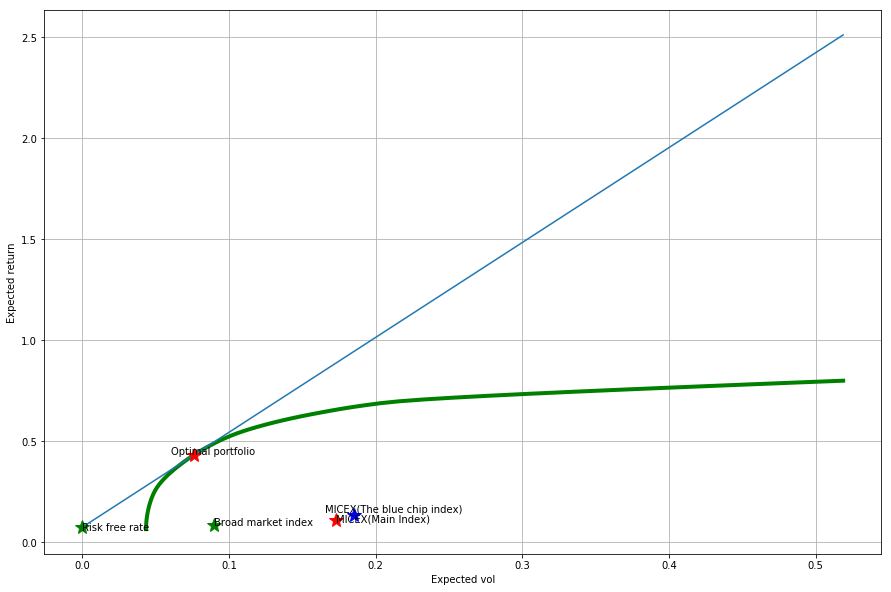

In [108]:
_=plt.figure(figsize = (15,10))
_=plt.plot(evols, erets, 'g', lw = 4.0)
cx = np.linspace(0, max(lvols))
_=plt.plot(cx, opt[0] + opt[1] * cx, lw = 1.5)
_=plt.plot(opt[2], f(opt[2], tck),'r*',markersize=15)
_=plt.grid(True)
_=plt.xlabel('Expected vol')
_=plt.ylabel('Expected return')
_=plt.plot(MOEXBC_vol, MOEXBC_rent, 'b*', markersize=15)
_=plt.annotate('MICEX(The blue chip index)', xy=(MOEXBC_vol * .89, MOEXBC_rent * 1.1))
_=plt.plot(MICEX_vol, MICEX_rent, 'r*', markersize=15)
_=plt.annotate('MICEX(Main Index)', xy = (MICEX_vol, MICEX_rent * .88))
_=plt.plot(BMI_vol, BMI_rent, 'g*', markersize=15)
_=plt.annotate('Broad market index', xy = (BMI_vol, BMI_rent))
_=plt.annotate('Optimal portfolio', xy=(opt[2] * .79, f(opt[2], tck)))
_=plt.plot(0, r_f, 'g*', markersize=15)
_=plt.annotate('Risk free rate', xy=(0, r_f * 0.8))

In [110]:
# tangent portfolio
res = sco.minimize(port_vol, w_initial, (cov), method = 'SLSQP', bounds = bnds,constraints = cons)
# weights of tangent portfolio
dt = dict(Tiket = BMI_moex, Weights = list(res['x']))
dt = pd.DataFrame(dt)
dt = dt[dt['Weights'] > 0.0001]
print(dt)
# # profitability
print('Profitability: ', np.around(f(opt[2],tck) * 100, 2), '%', sep='')

      Tiket   Weights
16  CHMF.ME  0.968446
81  MSTT.ME  0.031554
Profitability: 43.29%


### The optimal portfolio consists of CHMF - 41,2% and MSTT - 2,3%
### This portfolio has a yield: 43,29%

## Summary
#### As you can see, the indices presented on the Moscow Exchange differ from the optimal portfolio. However, all the optimal portfolios we received consist of one or three shares.  What makes these portfolios very risky. Accordingly, for better forecasting, it is necessary to push the time window during which the yield and volatility of assets are considered.